## 4.1 Geometric Brownian Motion

In this question, we will look at ways to obtain the expected values of stochastic differential equations. We will consider a special case of Geometric Brownian Motion where 

$$b(t, Y_t) = \mu Y_t, h(t, Y_t) = \sigma Y_t,$$

with $\mu = 0.05$, $\sigma = 0.2$, $Y_0 = 1$, and $0 < t < 1$. For instance, this can be considered as a very simple model for the price of a stock. We will also consider a payoff function for the stock that is given by the random variable

$$P = \exp(-0.05) \max(0, Y(1) - 1).$$

### MLMC Questions

**1.** Write a code to simulate Geometric Brownian Motion for a given timestep $\Delta t$.
* Verify the mean and variance of $Y (1)$ using the analytic solution: 

$$Y_t = Y_0 \exp ((\mu − \frac{\sigma^2}{2})t + \sigma W_t)$$

You may use Monte Carlo to verify your code.
* What is the variance of a Monte Carlo estimator of the mean?

**2.** Adjust your code to simulate two processes, one with $\Delta t$ and another with $4\Delta t$ that share the underlying realization of the Wiener process every $4\Delta t$.

**3.** Write a code to perform Multilevel Monte Carlo (MLMC) to estimate the expectation $E[Y(1)]$ and verify your analytic solution. Modify your code for estimating $E[P]$.

* Use a four-level MLMC scheme with $(\Delta t)_i = 4^{-i}$ for $i = 2, 3, 4, 5$ for each of the levels. We will call the result that has a timestep of $4^{-5}$ the "high fidelity" model.
* Make a plot of the variance for each level of this estimator. Discuss.
* Make a plot of the expectation for each level of this estimator. Discuss.

**4.** What is the theoretical cost of the MLMC estimator? Use this theoretical cost to determine an expression for the optimal sample allocation for a given target accuracy.

**5.** Using the optimal sample allocation for several target accuracies, determine:
* What would be the required number of Monte Carlo samples of the high-fidelity model to achieve the same accuracies?
* Make a plot showing Estimator variance vs. Equivalent number of high-fidelity evaluations for both Monte Carlo and MLMC. Discuss.


In [1]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

### Problem 4.1 (1a)

In [2]:
def brownian_motion_simulate(T, dt, num_paths):
    nsamples = int(np.floor(T / dt)) + 1
    samples = np.random.randn(nsamples, num_paths) * np.sqrt(dt)
    samples[0] = 0.0
    bmotion = np.cumsum(samples, axis=0)
    return bmotion

In [3]:
def brownian_motion_fine_to_coarse(T, dt, brownian_fine, M): 
    nsamples = int(np.ceil(T/dt)) + 1
    npaths = brownian_fine.shape[1]
    brownian_coarse = np.zeros((nsamples, npaths))
    brownian_coarse[0, :] = brownian_fine[0, :]
    for ii in range(1, nsamples):
        delta = brownian_fine[ii * M, :] - brownian_fine[(ii-1)*M, :]
        brownian_coarse[ii, :] = brownian_coarse[ii-1, :] + delta
    return brownian_coarse

In [4]:
def euler_maruyama(b, h, x0, dt, T, bmotion):

    num_paths = x0.shape[0]
    assert bmotion.shape[1] >= num_paths, "Not enough brownian motions simulated"
    num_steps = int(np.ceil(T / dt)) + 1
    paths = np.zeros((num_steps, num_paths))
    paths[0, :] = x0
    times = np.zeros(num_steps)
    t = 0
    for ii in range(1, num_steps):
        paths[ii, :] = paths[ii-1, :] + b(t, paths[ii-1, :]) * dt + h(t, paths[ii-1, :]) * (bmotion[ii, :] - bmotion[ii-1, :])
        t += dt
        times[ii] = t;
    return times, paths

In [5]:
mu = 0.05
sigma = 0.2
b = lambda t, y: mu * y
h = lambda t, y: sigma * y

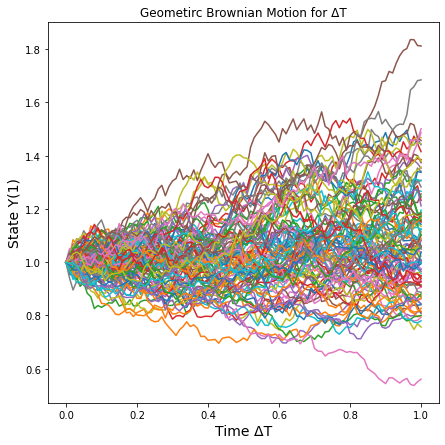

1.0238661751968923
0.009709714340272223


In [6]:
T = 1
dt = 1e-2
num_paths = 100
bmotion_411a = brownian_motion_simulate(T, dt, num_paths)
#print(bmotion)
y0 = np.ones((num_paths)) # start at 1
t_fin_411a, y_states_411a = euler_maruyama(b, h, y0, dt, T, bmotion_411a)

plt.figure(figsize=(7, 7))
plt.plot(t_fin_411a, y_states_411a)
plt.xlabel('Time \u0394T', fontsize=14)
plt.ylabel('State Y(1)', fontsize=14)
plt.title('Geometirc Brownian Motion for \u0394T')
plt.show()

y_f_411a = y_states_411a[:,-1]
bmotion_f_411a = bmotion_411a[:,-1]
mean_y_411a = sum(y_f_411a)/num_paths
var_y_411a = np.var(y_f_411a)
print(mean_y_411a)
print(var_y_411a)
#print(t_fin_411a)
#print(y_states_411a)

In [7]:
# Analytical solution 
Y0_411a = 1
t_f = 1
Y_an_f_411a = Y0_411a * np.exp((mu - (sigma**2/2))*t_f + (sigma*bmotion_f_411a))
mean_y_an_411a = sum(Y_an_f_411a)/num_paths
var_y_an_411a = np.var(Y_an_f_411a)
print(mean_y_an_411a)
print(var_y_an_411a)

1.0372263407547058
0.008558243015729479


### Problem 4.1 (1b)

In [8]:
T = 1
dt = 1e-2
num_paths = 1000
mc_runs = 1000 
b = lambda t, y: mu * y
h = lambda t, y: sigma * y
y0 = np.ones((num_paths))
#bmotion_411b_matrix = np.zeros((mc_runs,num_paths))
S_f_states_411b = np.zeros(mc_runs)

for ii in range(mc_runs):
    bmotion_411b = brownian_motion_simulate(T, dt, num_paths)
    t_fin_411b, y_states_411b = euler_maruyama(b, h, y0, dt, T, bmotion_411b)
    y_f_states_411b = y_states_411b[-1,:]
    S_f_states_411b[ii] = np.sum(y_f_states_411b)/num_paths
# mean_411b = np.sum(S_f_states_411b)/mc_runs
var_411b = np.var(S_f_states_411b)

#print(mean_411b)
#print(var_411b)
#print(y_states_411b.shape)
#print(y_f_states_411b.shape)
#print(S_f_states_411b)
print(var_411b)
print(S_f_states_411b)

4.303662703232498e-05
[1.04391562 1.05154072 1.06146682 1.05506002 1.04947188 1.04520891
 1.05215792 1.0560015  1.04177639 1.04365951 1.03556214 1.04554734
 1.05805716 1.05822806 1.04471034 1.05586706 1.05067621 1.04734315
 1.06231439 1.07192899 1.04532831 1.04565521 1.06142277 1.06139101
 1.0512472  1.05017918 1.04242922 1.05963215 1.05260205 1.05329639
 1.05698214 1.05051854 1.04630787 1.05456202 1.06251699 1.05428613
 1.06113019 1.05638916 1.06005352 1.05843631 1.04753028 1.04641131
 1.04950299 1.04501033 1.04864731 1.05665419 1.05308791 1.04890238
 1.05066302 1.06033806 1.04793104 1.06145698 1.05832504 1.05776129
 1.04557382 1.05122159 1.04364154 1.05224498 1.05007527 1.05833618
 1.05457046 1.0519642  1.05554165 1.05524832 1.05354972 1.04268741
 1.05521439 1.04750168 1.04453175 1.06864331 1.07228702 1.04988047
 1.05157892 1.0420977  1.04626384 1.05189659 1.04844983 1.0575299
 1.04758715 1.06000514 1.06220501 1.04385241 1.0600253  1.04958578
 1.04858257 1.05353656 1.04066095 1.04922

### Problem 4.1 (2)

In [9]:
T = 1
dt = 1e-2
num_paths = 100
b = lambda t, y: mu * y
h = lambda t, y: sigma * y
y0 = np.ones((num_paths))
bmotion_dt_412 = brownian_motion_simulate(T, dt, num_paths)
bmotion_4dt_412 = bmotion_dt_412[::4,:]
t_fin_412a, y_states_412a = euler_maruyama(b, h, y0, dt, T, bmotion_dt_412)
# t_fin_412a_last = t_fin_412a[-1,:]
bmotion_dt_412_last = bmotion_dt_412[-1,:]
t_fin_412b, y_states_412b = euler_maruyama(b, h, y0, 4*dt, T, bmotion_4dt_412)
# t_fin_412b_last = t_fin_412b[-1,:]
bmotion_4dt_412_last = bmotion_dt_412[-1,:]
# fig, ax = plt.subplots(2,figsize=(11, 11))
# ax[0].plot(t_fin_412a, y_states_412a)
# ax[1].plot(t_fin_412b, y_states_412b)
# ax[0].set_xlabel('Time', fontsize=12)
# ax[0].set_ylabel('State Y(1)', fontsize=12)
# ax[0].set_title("Geometric Brownian Motion for \u0394T")
# ax[1].set_xlabel('Time', fontsize=12)
# ax[1].set_ylabel('State Y(1)', fontsize=12)
# ax[1].set_title("Geometric Brownian Motion for 4\u0394T")
# plt.show()
# print(t_fin_412a)
# print(bmotion_dt_412[-1,:])
# print(t_fin_412b.shape)
# print(bmotion_4dt_412_last.shape)
# np.reshape(t_fin_412b, (100,1))

In [10]:
# M = 4
# DT = 0.025  # fine scale time step
# DTM = DT * M # coarse scale time step
# TFINAL = 1.0 # final time
# TSPAN_COARSE = np.arange(0, TFINAL + DTM, DTM)
# TSPAN_FINE = np.arange(0, TFINAL+DT, DT)
# brownian_fine = brownian_motion_simulate(TFINAL, DT)
# brownian_coarse = brownian_motion_fine_to_coarse(TFINAL, DTM, brownian_fine, M)

# plt.figure()
# plt.plot(t_fin_412a[0:100], bmotion_dt_412_last, '-ko', label='Fine-scale simulation')
# plt.plot(t_fin_412b[0:100], bmotion_4dt_412_last, '--rx', label='Coarse-scale simulation')

# plt.xlabel('Time', fontsize=14)
# plt.ylabel(r'$W_t$', fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Problem 4.1 (3a)

In [11]:
ou_bfunc = lambda t, y: mu * y
ou_hfunc = lambda t, y: sigma * y

def evaluator(bmotion, dt, T):
   
    num_paths = bmotion.shape[1]
    x0 = np.ones((num_paths)) # start at 1
    times, states = euler_maruyama(ou_bfunc, ou_hfunc, x0, dt, T, bmotion)
    res = states[-1,:]
    res = res[:, np.newaxis] # make this an N x 1 array, which is what we need for the monte carlo function
    return res

In [12]:
def multilevel_montecarlo_sde(func, nsamples_L0, nsamples_L1, nsamples_L2, nsamples_L3, nsamples_L4, dt_L4_fine, T, M):
    """Multilevel Monte Carlo for Stochastic differential equations"""
    
    dt_L3_fine = dt_L4_fine * M 
    dt_L2_fine = dt_L3_fine * M 
    dt_L1_fine = dt_L2_fine * M 
    dt_coarse = dt_L1_fine * M
    
    ###########################
    # level 0 Only coarse grid evaluations are used
    ###########################
    bmotion_L0 = brownian_motion_simulate(T, dt_coarse, nsamples_L0)
    samples_L0 = func(bmotion_L0, dt_coarse, T)
    
    #####################
    # level 1
    ######################
    # First generate fine and coarse bmotion samples
    bmotion_L1_fine = brownian_motion_simulate(T, dt_L1_fine, nsamples_L1)
    bmotion_L1_coarse = brownian_motion_fine_to_coarse(T, dt_coarse, bmotion_L1_fine, M)
        
    # Next evaluate the samples
    samples_L1_fine = func(bmotion_L1_fine, dt_L1_fine, T)
    samples_L1_coarse = func(bmotion_L1_coarse, dt_coarse, T)

    # Now subtract
    samples_L1_del = samples_L1_fine - samples_L1_coarse
    
    #####################
    # level 2
    ######################
    # First generate fine and coarse bmotion samples
    bmotion_L2_fine = brownian_motion_simulate(T, dt_L2_fine, nsamples_L2)
    bmotion_L2_coarse = brownian_motion_fine_to_coarse(T, dt_L1_fine, bmotion_L2_fine, M)
        
    # Next evaluate the samples
    samples_L2_fine = func(bmotion_L2_fine, dt_L2_fine, T)
    samples_L2_coarse = func(bmotion_L2_coarse, dt_L1_fine, T)

    # Now subtract
    samples_L2_del = samples_L2_fine - samples_L2_coarse
    #####################
    # level 3
    ######################
    # First generate fine and coarse bmotion samples
    bmotion_L3_fine = brownian_motion_simulate(T, dt_L3_fine, nsamples_L3)
    bmotion_L3_coarse = brownian_motion_fine_to_coarse(T, dt_L2_fine, bmotion_L3_fine, M)
        
    # Next evaluate the samples
    samples_L3_fine = func(bmotion_L3_fine, dt_L3_fine, T)
    samples_L3_coarse = func(bmotion_L3_coarse, dt_L2_fine, T)

    # Now subtract
    samples_L3_del = samples_L3_fine - samples_L3_coarse
        #####################
    # level 4
    ######################
    # First generate fine and coarse bmotion samples
    bmotion_L4_fine = brownian_motion_simulate(T, dt_L4_fine, nsamples_L4)
    bmotion_L4_coarse = brownian_motion_fine_to_coarse(T, dt_L3_fine, bmotion_L4_fine, M)
        
    # Next evaluate the samples
    samples_L4_fine = func(bmotion_L4_fine, dt_L4_fine, T)
    samples_L4_coarse = func(bmotion_L4_coarse, dt_L3_fine, T)

    # Now subtract
    samples_L4_del = samples_L4_fine - samples_L4_coarse
    
    #####################
    ## Combine levels
    #####################
    est_mean_L0 = np.mean(samples_L0)
    est_mean_L1 = np.mean(samples_L1_fine)
    est_mean_L2 = np.mean(samples_L2_fine)
    est_mean_L3 = np.mean(samples_L3_fine)
    est_mean_L4 = np.mean(samples_L4_fine)
    
    est_mean_Y_1 = est_mean_L0 + est_mean_L1 + est_mean_L2 + est_mean_L3 + est_mean_L4
    
    est_var_L0 = np.var(samples_L0)
    est_var_L1 = np.var(samples_L1_fine)
    est_var_L2 = np.var(samples_L2_fine)
    est_var_L3 = np.var(samples_L3_fine)
    est_var_L4 = np.var(samples_L4_fine)

    est_var_del_1 = np.var(samples_L1_del)
    est_var_del_2 = np.var(samples_L2_del)
    est_var_del_3 = np.var(samples_L3_del)
    est_var_del_4 = np.var(samples_L4_del)

    return est_mean_Y_1, est_mean_L0, est_mean_L1, est_mean_L2, est_mean_L3, est_mean_L4, est_var_L0, est_var_L1, est_var_L2, est_var_L3, est_var_L4, est_var_del_1, est_var_del_2, est_var_del_3, est_var_del_4

### Problem 4.1 (3b)

In [13]:
ou_bfunc = lambda t, y: mu * y
ou_hfunc = lambda t, y: sigma * y
num_paths = 1000
def p_evaluator(bmotion, dt, T):
   
    num_paths = bmotion.shape[1]
    p = np.zeros((num_paths))
    x0 = np.ones((num_paths)) # start at 1
    times, states = euler_maruyama(ou_bfunc, ou_hfunc, x0, dt, T, bmotion)
    for ii in range((num_paths)):
        p[ii] = np.exp(-0.05)*np.maximum(0,states[-1,ii]-1)
    res = p[:, np.newaxis] # make this an N x 1 array, which is what we need for the monte carlo function
    return res

In [14]:
dt_fine_L4 = 1/4**(5)
M = 4
T = 1
nsamples_0 = 1000 #level 0 
nsamples_1 = 800 #level 1
nsamples_2 = 600 #level 2
nsamples_3 = 400 #level 3
nsamples_4 = 200 #level 4
est_mean_of_peval,_,_,_,_,_,_,_,_,_,_,_,_,_,_ = multilevel_montecarlo_sde(evaluator,nsamples_0, nsamples_1, nsamples_2, nsamples_3, nsamples_4, dt_fine_L4, T, M)
est_mean_of_eval,_,_,_,_,_,_,_,_,_,_,_,_,_,_ = multilevel_montecarlo_sde(p_evaluator,nsamples_0, nsamples_1, nsamples_2, nsamples_3, nsamples_4, dt_fine_L4, T, M)
print(est_mean_of_peval)
print(est_mean_of_eval)

5.249000743350909
0.5341834985356338


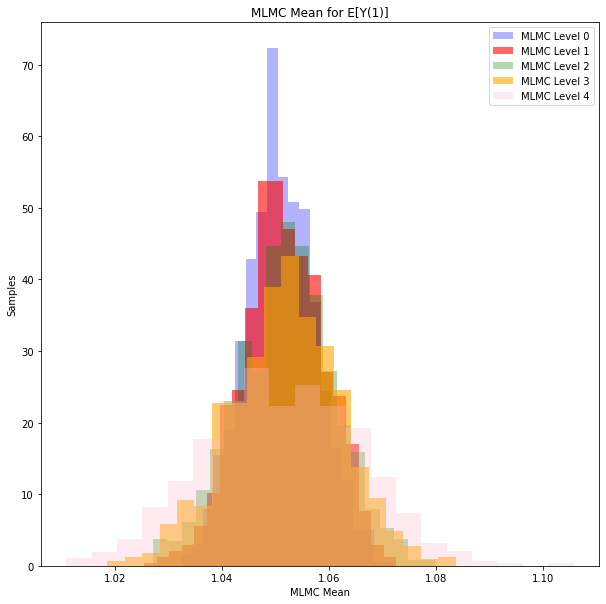

In [15]:
ntrials = 1000

L0_mean_Y = np.zeros((ntrials))
L1_mean_Y = np.zeros((ntrials))
L2_mean_Y = np.zeros((ntrials))
L3_mean_Y = np.zeros((ntrials))
L4_mean_Y = np.zeros((ntrials))

L0_var_Y = np.zeros((ntrials))
L1_var_Y = np.zeros((ntrials))
L2_var_Y = np.zeros((ntrials))
L3_var_Y = np.zeros((ntrials))
L4_var_Y = np.zeros((ntrials))

L1_var_del_Y = np.zeros((ntrials))
L2_var_del_Y = np.zeros((ntrials))
L3_var_del_Y = np.zeros((ntrials))
L4_var_del_Y = np.zeros((ntrials))

for ii in range(ntrials):
    mean_p_y, mean_L0_y, mean_L1_y, mean_L2_y, mean_L3_y, mean_L4_y, var_L0_y, var_L1_y,\
    var_L2_y, var_L3_y, var_L4_y, var_del_L1_y, var_del_L2_y, var_del_L3_y, var_del_L4_y\
    = multilevel_montecarlo_sde(evaluator,nsamples_0, nsamples_1, nsamples_2,\
    nsamples_3, nsamples_4, dt_fine_L4, T, M)
    
    L0_mean_Y[ii] = mean_L0_y
    L1_mean_Y[ii] = mean_L1_y
    L2_mean_Y[ii] = mean_L2_y
    L3_mean_Y[ii] = mean_L3_y
    L4_mean_Y[ii] = mean_L4_y
    
    L0_var_Y[ii] = var_L0_y
    L1_var_Y[ii] = var_L1_y
    L2_var_Y[ii] = var_L2_y
    L3_var_Y[ii] = var_L3_y
    L4_var_Y[ii] = var_L4_y
    
    L1_var_del_Y[ii] = var_del_L1_y
    L2_var_del_Y[ii] = var_del_L2_y
    L3_var_del_Y[ii] = var_del_L3_y
    L4_var_del_Y[ii] = var_del_L4_y
        
plt.figure(figsize=(10,10))
plt.hist(L0_mean_Y, density=True, color='blue', label='MLMC Level 0',alpha=0.3, bins=20)
plt.hist(L1_mean_Y, density=True, color='red', label='MLMC Level 1',alpha=0.6, bins=20)
plt.hist(L2_mean_Y, density=True, color='green', label='MLMC Level 2',alpha=0.3, bins=20)
plt.hist(L3_mean_Y, density=True, color='orange', label='MLMC Level 3',alpha=0.6, bins=20)
plt.hist(L4_mean_Y, density=True, color='pink', label='MLMC Level 4',alpha=0.3, bins=20)
plt.xlabel('MLMC Mean')
plt.ylabel('Samples')
plt.title('MLMC Mean for E[Y(1)]')
plt.legend()
plt.show()

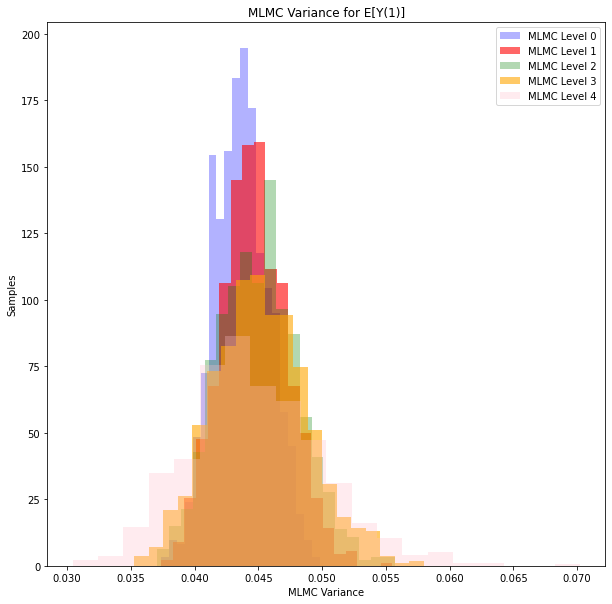

In [16]:
plt.figure(figsize=(10,10))
plt.hist(L0_var_Y, density=True, color='blue', label='MLMC Level 0',alpha=0.3, bins=20)
plt.hist(L1_var_Y, density=True, color='red', label='MLMC Level 1',alpha=0.6, bins=20)
plt.hist(L2_var_Y, density=True, color='green', label='MLMC Level 2',alpha=0.3, bins=20)
plt.hist(L3_var_Y, density=True, color='orange', label='MLMC Level 3',alpha=0.6, bins=20)
plt.hist(L4_var_Y, density=True, color='pink', label='MLMC Level 4',alpha=0.3, bins=20)
plt.xlabel('MLMC Variance')
plt.ylabel('Samples')
plt.title('MLMC Variance for E[Y(1)]')
plt.legend()
plt.show()

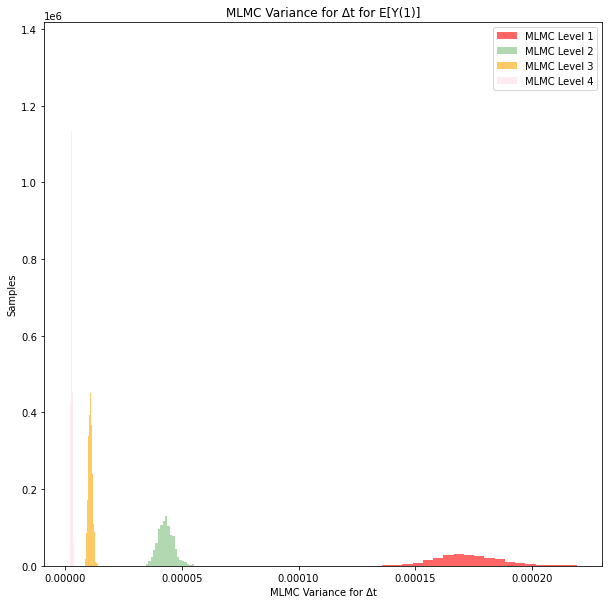

In [17]:
plt.figure(figsize=(10,10))
plt.hist(L1_var_del_Y, density=True, color='red', label='MLMC Level 1',alpha=0.6, bins=20)
plt.hist(L2_var_del_Y, density=True, color='green', label='MLMC Level 2',alpha=0.3, bins=20)
plt.hist(L3_var_del_Y, density=True, color='orange', label='MLMC Level 3',alpha=0.6, bins=20)
plt.hist(L4_var_del_Y, density=True, color='pink', label='MLMC Level 4',alpha=0.3, bins=20)
plt.xlabel('MLMC Variance for \u0394t')
plt.ylabel('Samples')
plt.title('MLMC Variance for \u0394t for E[Y(1)]')
plt.legend()
plt.show()

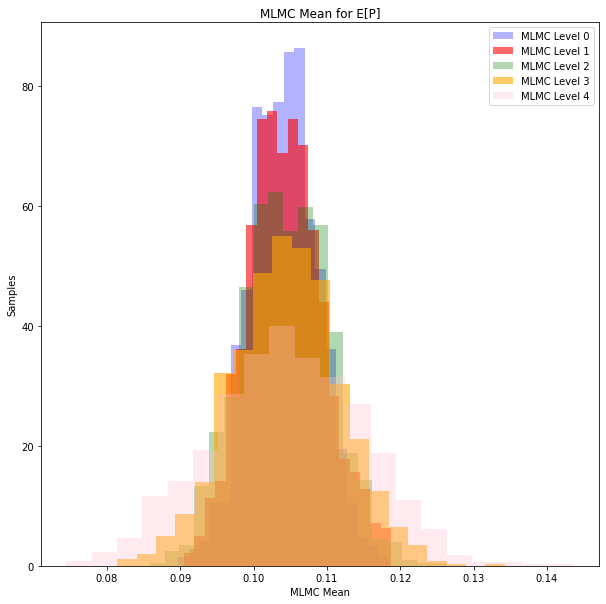

In [18]:
ntrials = 1000

L0_mean_p = np.zeros((ntrials))
L1_mean_p = np.zeros((ntrials))
L2_mean_p = np.zeros((ntrials))
L3_mean_p = np.zeros((ntrials))
L4_mean_p = np.zeros((ntrials))

L0_var_p = np.zeros((ntrials))
L1_var_p = np.zeros((ntrials))
L2_var_p = np.zeros((ntrials))
L3_var_p = np.zeros((ntrials))
L4_var_p = np.zeros((ntrials))

L1_var_del_p = np.zeros((ntrials))
L2_var_del_p = np.zeros((ntrials))
L3_var_del_p = np.zeros((ntrials))
L4_var_del_p = np.zeros((ntrials))

for ii in range(ntrials):
    mean_p_p, mean_L0_p, mean_L1_p, mean_L2_p, mean_L3_p, mean_L4_p, var_L0_p, var_L1_p,\
    var_L2_p, var_L3_p, var_L4_p, var_del_L1_p, var_del_L2_p, var_del_L3_p, var_del_L4_p\
    = multilevel_montecarlo_sde(p_evaluator,nsamples_0, nsamples_1, nsamples_2,\
    nsamples_3, nsamples_4, dt_fine_L4, T, M)
    
    L0_mean_p[ii] = mean_L0_p
    L1_mean_p[ii] = mean_L1_p
    L2_mean_p[ii] = mean_L2_p
    L3_mean_p[ii] = mean_L3_p
    L4_mean_p[ii] = mean_L4_p
    
    L0_var_p[ii] = var_L0_p
    L1_var_p[ii] = var_L1_p
    L2_var_p[ii] = var_L2_p
    L3_var_p[ii] = var_L3_p
    L4_var_p[ii] = var_L4_p
    
    L1_var_del_p[ii] = var_del_L1_p
    L2_var_del_p[ii] = var_del_L2_p
    L3_var_del_p[ii] = var_del_L3_p
    L4_var_del_p[ii] = var_del_L4_p
        
plt.figure(figsize=(10,10))
plt.hist(L0_mean_p, density=True, color='blue', label='MLMC Level 0',alpha=0.3, bins=20)
plt.hist(L1_mean_p, density=True, color='red', label='MLMC Level 1',alpha=0.6, bins=20)
plt.hist(L2_mean_p, density=True, color='green', label='MLMC Level 2',alpha=0.3, bins=20)
plt.hist(L3_mean_p, density=True, color='orange', label='MLMC Level 3',alpha=0.6, bins=20)
plt.hist(L4_mean_p, density=True, color='pink', label='MLMC Level 4',alpha=0.3, bins=20)
plt.xlabel('MLMC Mean')
plt.ylabel('Samples')
plt.title('MLMC Mean for E[P]')
plt.legend()
plt.show()

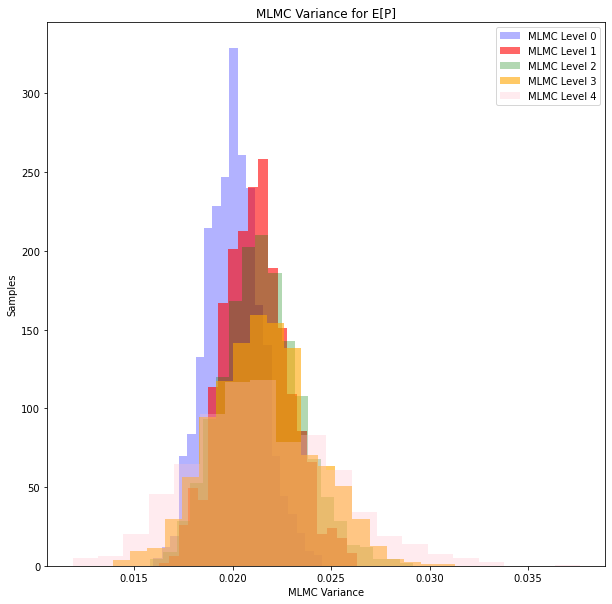

In [19]:
plt.figure(figsize=(10,10))
plt.hist(L0_var_p, density=True, color='blue', label='MLMC Level 0',alpha=0.3, bins=20)
plt.hist(L1_var_p, density=True, color='red', label='MLMC Level 1',alpha=0.6, bins=20)
plt.hist(L2_var_p, density=True, color='green', label='MLMC Level 2',alpha=0.3, bins=20)
plt.hist(L3_var_p, density=True, color='orange', label='MLMC Level 3',alpha=0.6, bins=20)
plt.hist(L4_var_p, density=True, color='pink', label='MLMC Level 4',alpha=0.3, bins=20)
plt.xlabel('MLMC Variance')
plt.ylabel('Samples')
plt.title('MLMC Variance for E[P]')
plt.legend()
plt.show()

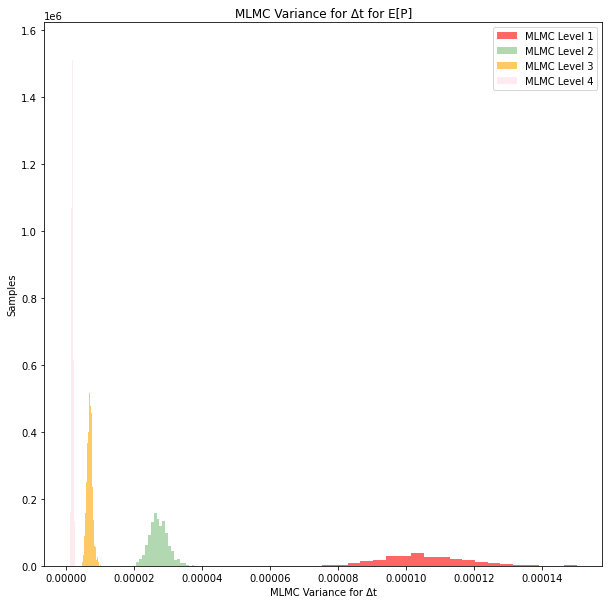

In [20]:
plt.figure(figsize=(10,10))
plt.hist(L1_var_del_p, density=True, color='red', label='MLMC Level 1',alpha=0.6, bins=20)
plt.hist(L2_var_del_p, density=True, color='green', label='MLMC Level 2',alpha=0.3, bins=20)
plt.hist(L3_var_del_p, density=True, color='orange', label='MLMC Level 3',alpha=0.6, bins=20)
plt.hist(L4_var_del_p, density=True, color='pink', label='MLMC Level 4',alpha=0.3, bins=20)
plt.xlabel('MLMC Variance for \u0394t')
plt.ylabel('Samples')
plt.title('MLMC Variance for \u0394t for E[P]')
plt.legend()
plt.show()